In [0]:
import torch
import torch.nn as nn
import torchvision as tv
from torch.utils.data import DataLoader

import numpy as np
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt

from typing import Tuple, List

%matplotlib inline

In [0]:
def get_mnist_ds(is_train:bool):
    return tv.datasets.MNIST(root = Path('mnistdata'),
                             train = is_train,
                             transform = tv.transforms.ToTensor(),
                             target_transform = None,
                             download = True
                            )

In [0]:
def get_mnist_ds_loader(batch_size):
        train_ds = get_mnist_ds(is_train = True)
        valid_ds = get_mnist_ds(is_train = False)
        
        return (DataLoader(train_ds, batch_size, shuffle = True),
                DataLoader(valid_ds, 2*batch_size, shuffle = False))
    

In [4]:
train_dl, valid_dl = get_mnist_ds_loader(32)


Extracting mnistdata/MNIST/raw/train-images-idx3-ubyte.gz to mnistdata/MNIST/raw



Extracting mnistdata/MNIST/raw/train-labels-idx1-ubyte.gz to mnistdata/MNIST/raw



Extracting mnistdata/MNIST/raw/t10k-images-idx3-ubyte.gz to mnistdata/MNIST/raw



Extracting mnistdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnistdata/MNIST/raw
Processing...
Done!


In [5]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [6]:
train_dl.dataset.data.shape

torch.Size([60000, 28, 28])

torch.Size([32, 1, 28, 28])
torch.Size([32])


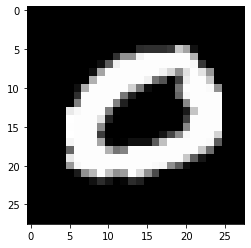

torch.Size([32, 1, 28, 28])
torch.Size([32])


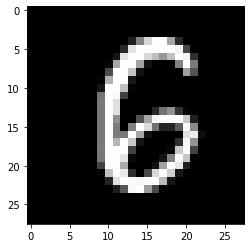

torch.Size([32, 1, 28, 28])
torch.Size([32])


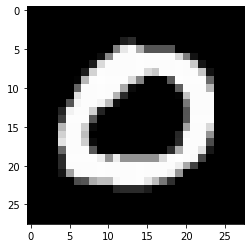

torch.Size([32, 1, 28, 28])
torch.Size([32])


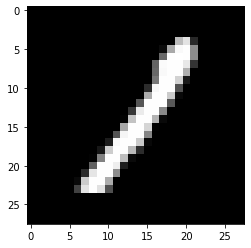

torch.Size([32, 1, 28, 28])
torch.Size([32])


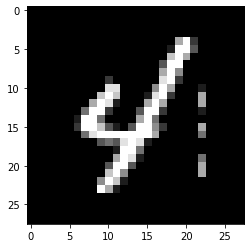

In [7]:
for i, x in enumerate(train_dl):
    print(x[0].shape)
    print(x[1].shape)
    plt.imshow(x[0][0][0],cmap='gray')
    plt.show()
    if i>3 : break

In [0]:
class Encoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_size), hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, out_size))
        
    def forward(self, x):
        return self.enc(x)
        

In [0]:
class Decoder(nn.Module):
    def __init__(self, inp_size: int, hidden_size: int, out_size: Tuple[int,int]):
        
        super().__init__()
        self.out_size = out_size
        self.dec = nn.Sequential(nn.Linear(inp_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, np.prod(out_size)),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.dec(x)
        return x.view((x.shape[0],*self.out_size))

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        super().__init__()
        
        self.enc = Encoder(inp_size, hidden_size, out_size)
        self.dec = Decoder(out_size, hidden_size, inp_size)
        
    def forward(self, x):
        out = self.enc(x)
        out = self.dec(out)
        
        return out

In [12]:
ae = AutoEncoder(inp_size=(28,28),hidden_size=512,out_size=20)
ae

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [0]:
x, y = valid_dl.dataset[30]

In [14]:
print(x.shape)
print(x.requires_grad)

torch.Size([1, 28, 28])
False


In [18]:
with torch.no_grad():
    out = ae(x)
print(out.shape)
print(out.requires_grad)

torch.Size([1, 28, 28])
False


In [19]:
out = ae(x)
print(out.shape)
print(out.requires_grad)

torch.Size([1, 28, 28])
True


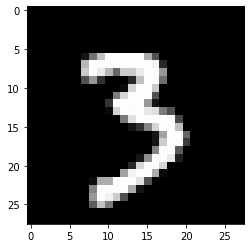

In [22]:
plt.imshow(x[0], cmap='gray')

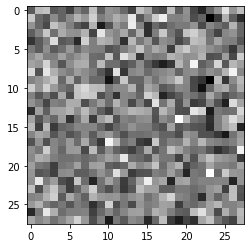

In [23]:
plt.imshow(out[0].detach(),cmap='gray')

In [0]:
def show_summary(valid_dl: DataLoader, model: nn.Module):
    ELEM_NUM = 10
    
    device = model.parameters().__next__().device
    ae.eval()

    actual_list = [x for i, (x, y) in enumerate(valid_dl.dataset) if i < ELEM_NUM]
    
    with torch.no_grad():
        actuals_batch = torch.cat(actual_list).unsqueeze(1)
        reconst_batch = ae(actuals_batch.to(device)).cpu().unsqueeze(1)
    
    ae.train()
    
    grid_elems = [*actuals_batch, *reconst_batch]

    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1, pad_value =1)
  
    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

In [0]:
def show_summary_1(valid_dl:DataLoader, model: nn.Module):
    ELEM_NUM = 15
    
    device = model.parameters().__next__().device
    ae.eval()
    
    actuals, reconst = [], []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            actuals.append(x)
            reconst.append(ae(x.to(device)).detach().cpu())
            if i == ELEM_NUM-1: break
    
    ae.train()
    
    grid_elems = [*actuals, *reconst]
    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1,pad_value=1)

    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

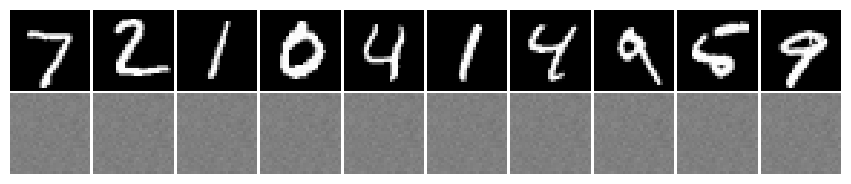

CPU times: user 1.31 s, sys: 2.88 ms, total: 1.32 s
Wall time: 1.34 s


In [26]:
%%time
show_summary(valid_dl,ae)

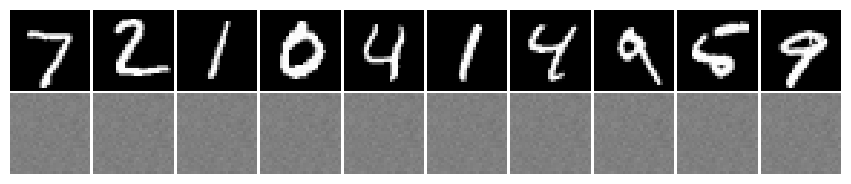

CPU times: user 240 ms, sys: 1.16 ms, total: 242 ms
Wall time: 243 ms


In [27]:
%%time
show_summary_1(valid_dl,ae)

In [0]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
seed_everything()

In [0]:
device = torch.device('cuda')
ae = ae.to(device)

In [0]:
def init_params(m:nn.Module):
    if type(m) == nn.Linear:
      nn.init.orthogonal_(m.weight.data)
      nn.init.zeros_(m.bias.data)
    

In [0]:
mse_loss = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr = 0.001)

epoch 0 | iter 0 | acc_cost 0.2319 | cost 0.2319


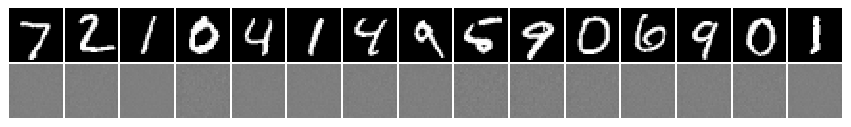

epoch 0 | iter 100 | acc_cost 7.4490 | cost 0.0413
epoch 0 | iter 200 | acc_cost 3.7306 | cost 0.0358


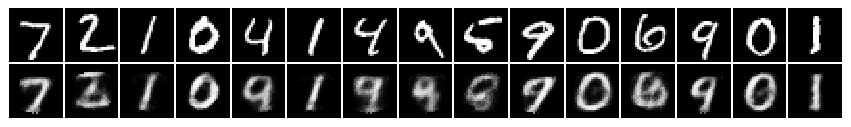

epoch 0 | iter 300 | acc_cost 2.8125 | cost 0.0275
epoch 0 | iter 400 | acc_cost 2.3672 | cost 0.0227


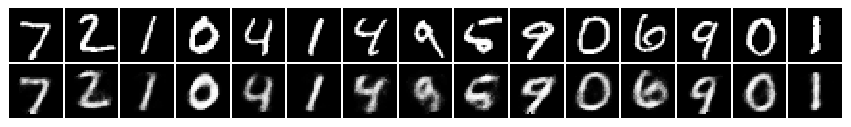

epoch 0 | iter 500 | acc_cost 2.0333 | cost 0.0217
epoch 0 | iter 600 | acc_cost 1.8453 | cost 0.0186


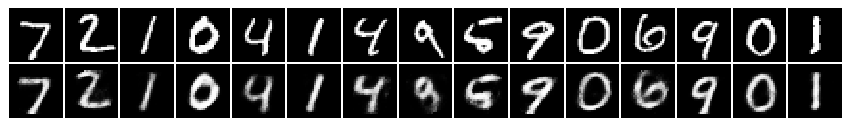

epoch 0 | iter 700 | acc_cost 1.7051 | cost 0.0154
epoch 0 | iter 800 | acc_cost 1.6282 | cost 0.0165


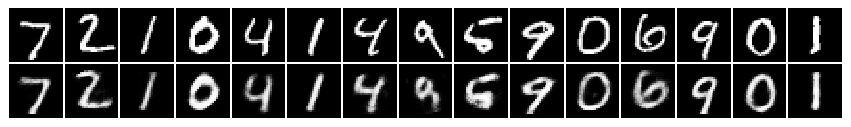

epoch 0 | iter 900 | acc_cost 1.4870 | cost 0.0132
epoch 0 | iter 1000 | acc_cost 1.4472 | cost 0.0115


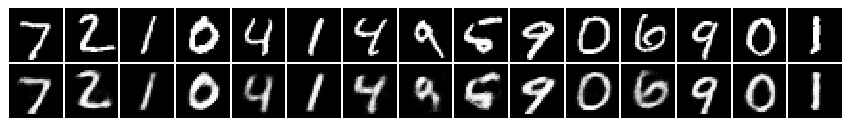

epoch 0 | iter 1100 | acc_cost 1.3854 | cost 0.0152
epoch 0 | iter 1200 | acc_cost 1.3637 | cost 0.0119


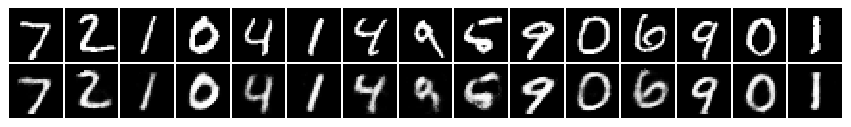

epoch 0 | iter 1300 | acc_cost 1.3071 | cost 0.0108
epoch 0 | iter 1400 | acc_cost 1.2721 | cost 0.0150


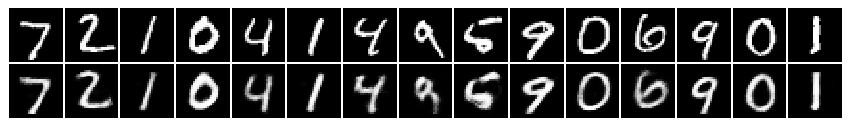

epoch 0 | iter 1500 | acc_cost 1.2783 | cost 0.0127
epoch 0 | iter 1600 | acc_cost 1.2282 | cost 0.0107


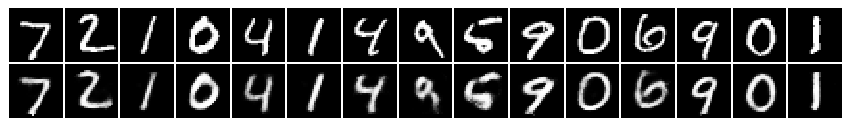

epoch 0 | iter 1700 | acc_cost 1.2237 | cost 0.0132
epoch 0 | iter 1800 | acc_cost 1.2038 | cost 0.0154


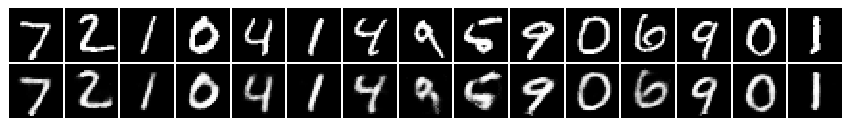

epoch 1 | iter 0 | acc_cost 0.8639 | cost 0.0099


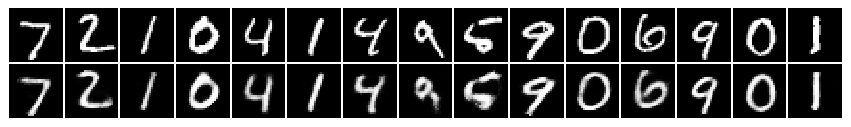

epoch 1 | iter 100 | acc_cost 1.1410 | cost 0.0114
epoch 1 | iter 200 | acc_cost 1.1501 | cost 0.0104


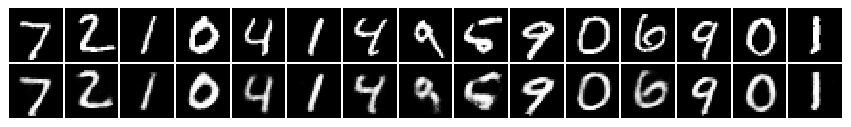

epoch 1 | iter 300 | acc_cost 1.1008 | cost 0.0108
epoch 1 | iter 400 | acc_cost 1.1246 | cost 0.0119


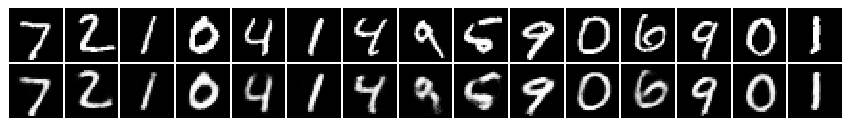

epoch 1 | iter 500 | acc_cost 1.0922 | cost 0.0102
epoch 1 | iter 600 | acc_cost 1.0924 | cost 0.0114


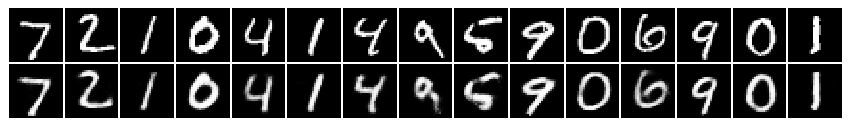

epoch 1 | iter 700 | acc_cost 1.0656 | cost 0.0095
epoch 1 | iter 800 | acc_cost 1.0746 | cost 0.0114


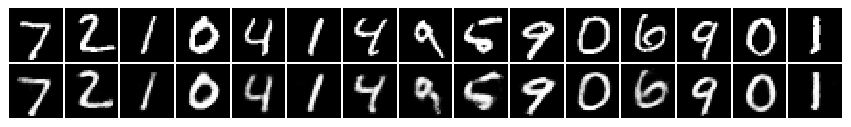

epoch 1 | iter 900 | acc_cost 1.0492 | cost 0.0101
epoch 1 | iter 1000 | acc_cost 1.0387 | cost 0.0114


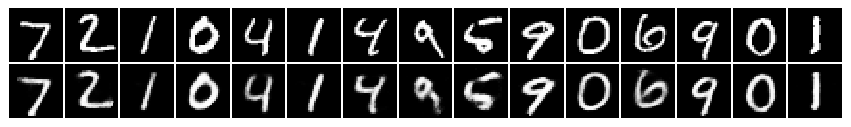

epoch 1 | iter 1100 | acc_cost 1.0348 | cost 0.0120
epoch 1 | iter 1200 | acc_cost 1.0112 | cost 0.0113


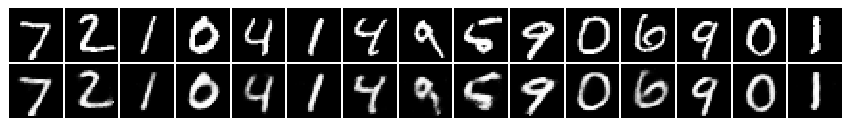

epoch 1 | iter 1300 | acc_cost 1.0288 | cost 0.0099
epoch 1 | iter 1400 | acc_cost 1.0039 | cost 0.0099


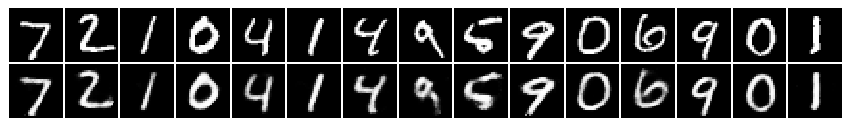

epoch 1 | iter 1500 | acc_cost 1.0143 | cost 0.0098
epoch 1 | iter 1600 | acc_cost 1.0114 | cost 0.0099


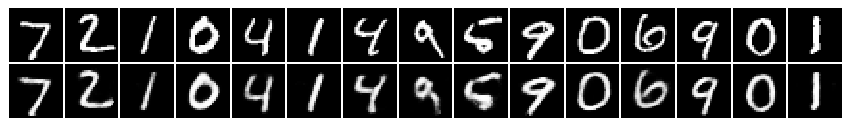

epoch 1 | iter 1700 | acc_cost 0.9764 | cost 0.0097
epoch 1 | iter 1800 | acc_cost 0.9716 | cost 0.0085


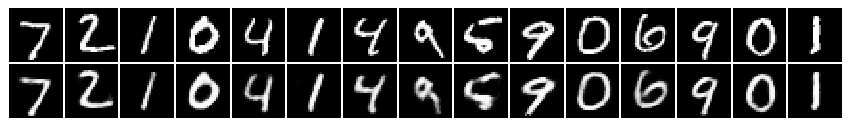

epoch 2 | iter 0 | acc_cost 0.7369 | cost 0.0103


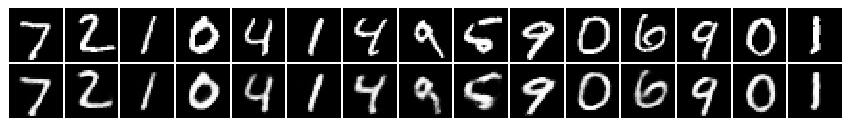

epoch 2 | iter 100 | acc_cost 0.9302 | cost 0.0086
epoch 2 | iter 200 | acc_cost 0.9439 | cost 0.0101


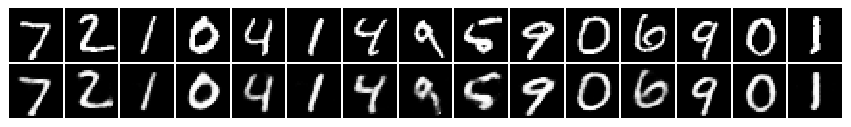

epoch 2 | iter 300 | acc_cost 0.9531 | cost 0.0111
epoch 2 | iter 400 | acc_cost 0.9413 | cost 0.0078


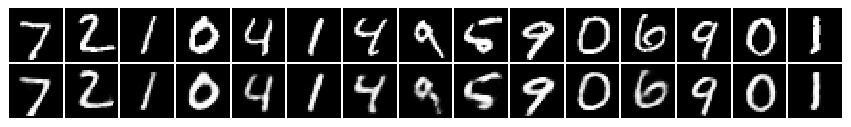

epoch 2 | iter 500 | acc_cost 0.9420 | cost 0.0091
epoch 2 | iter 600 | acc_cost 0.9426 | cost 0.0101


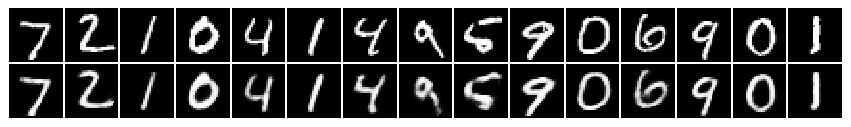

epoch 2 | iter 700 | acc_cost 0.9287 | cost 0.0085
epoch 2 | iter 800 | acc_cost 0.9330 | cost 0.0080


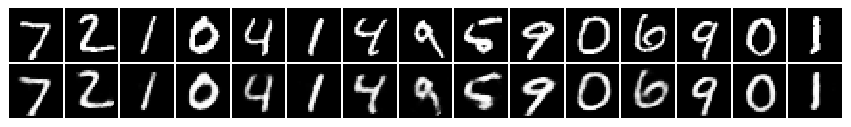

epoch 2 | iter 900 | acc_cost 0.9174 | cost 0.0083
epoch 2 | iter 1000 | acc_cost 0.8969 | cost 0.0090


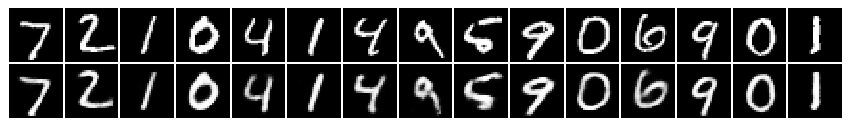

epoch 2 | iter 1100 | acc_cost 0.9008 | cost 0.0077
epoch 2 | iter 1200 | acc_cost 0.8924 | cost 0.0087


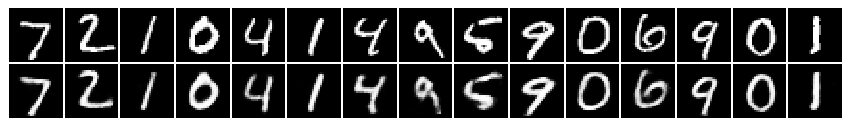

epoch 2 | iter 1300 | acc_cost 0.9111 | cost 0.0100
epoch 2 | iter 1400 | acc_cost 0.9049 | cost 0.0085


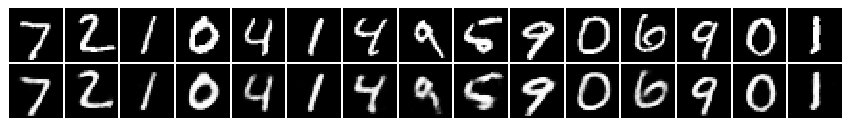

epoch 2 | iter 1500 | acc_cost 0.9051 | cost 0.0084
epoch 2 | iter 1600 | acc_cost 0.9061 | cost 0.0098


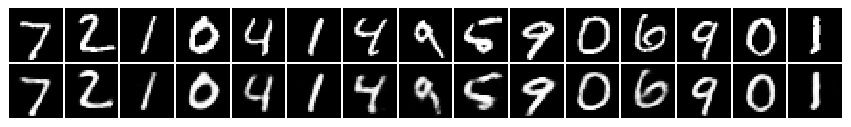

epoch 2 | iter 1700 | acc_cost 0.9040 | cost 0.0077
epoch 2 | iter 1800 | acc_cost 0.8897 | cost 0.0095


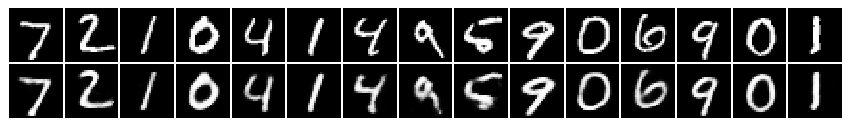

epoch 3 | iter 0 | acc_cost 0.6745 | cost 0.0092


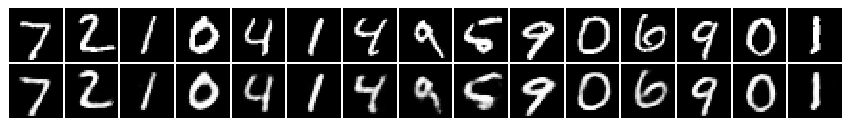

epoch 3 | iter 100 | acc_cost 0.8514 | cost 0.0075
epoch 3 | iter 200 | acc_cost 0.8659 | cost 0.0072


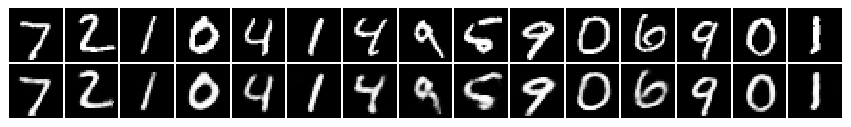

epoch 3 | iter 300 | acc_cost 0.8544 | cost 0.0091
epoch 3 | iter 400 | acc_cost 0.8782 | cost 0.0084


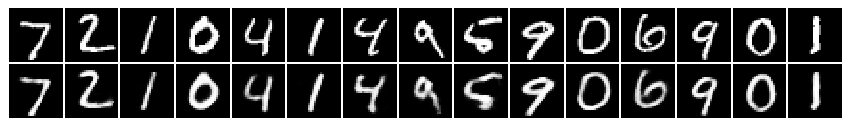

epoch 3 | iter 500 | acc_cost 0.8586 | cost 0.0083
epoch 3 | iter 600 | acc_cost 0.8530 | cost 0.0082


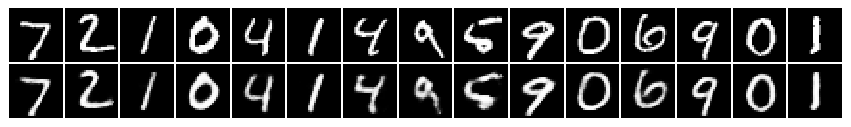

epoch 3 | iter 700 | acc_cost 0.8497 | cost 0.0091
epoch 3 | iter 800 | acc_cost 0.8587 | cost 0.0097


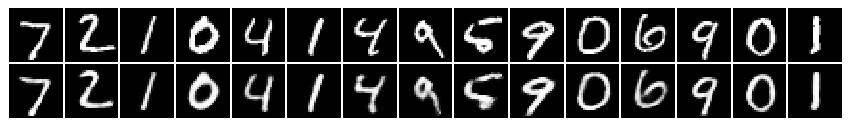

epoch 3 | iter 900 | acc_cost 0.8541 | cost 0.0075
epoch 3 | iter 1000 | acc_cost 0.8453 | cost 0.0095


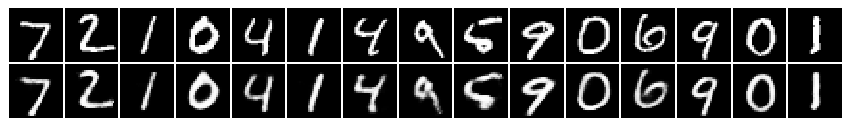

epoch 3 | iter 1100 | acc_cost 0.8468 | cost 0.0081
epoch 3 | iter 1200 | acc_cost 0.8493 | cost 0.0089


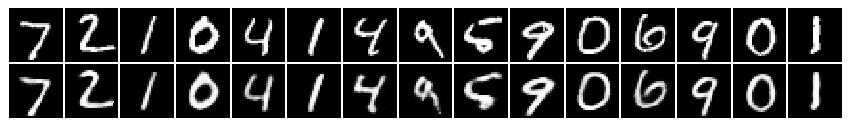

epoch 3 | iter 1300 | acc_cost 0.8402 | cost 0.0084
epoch 3 | iter 1400 | acc_cost 0.8350 | cost 0.0073


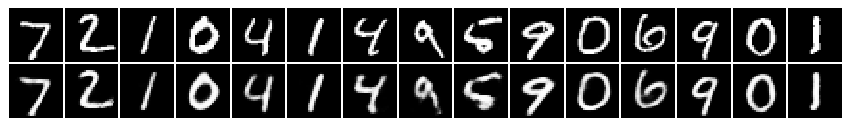

epoch 3 | iter 1500 | acc_cost 0.8417 | cost 0.0078
epoch 3 | iter 1600 | acc_cost 0.8397 | cost 0.0098


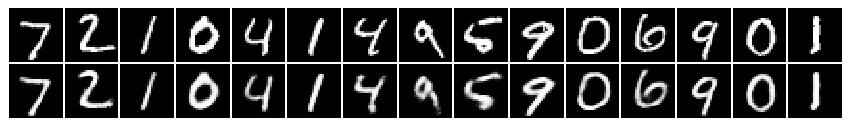

epoch 3 | iter 1700 | acc_cost 0.8181 | cost 0.0071
epoch 3 | iter 1800 | acc_cost 0.8273 | cost 0.0070


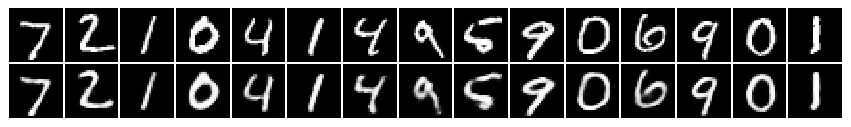

epoch 4 | iter 0 | acc_cost 0.6266 | cost 0.0091


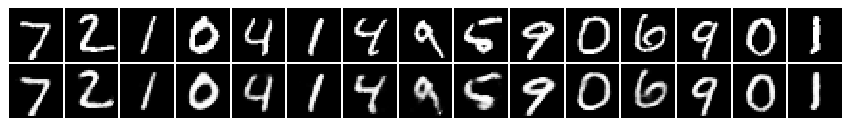

epoch 4 | iter 100 | acc_cost 0.7985 | cost 0.0095
epoch 4 | iter 200 | acc_cost 0.8063 | cost 0.0083


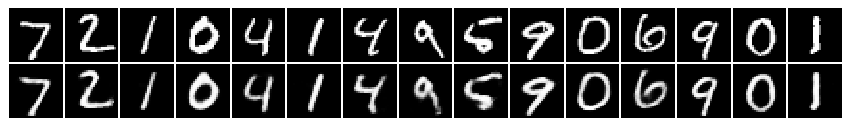

epoch 4 | iter 300 | acc_cost 0.7979 | cost 0.0060
epoch 4 | iter 400 | acc_cost 0.8044 | cost 0.0081


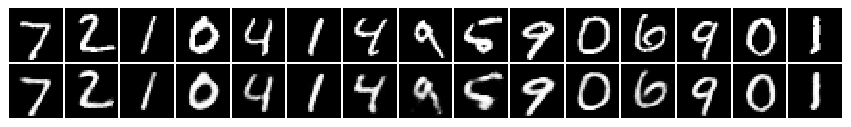

epoch 4 | iter 500 | acc_cost 0.8138 | cost 0.0085
epoch 4 | iter 600 | acc_cost 0.8219 | cost 0.0076


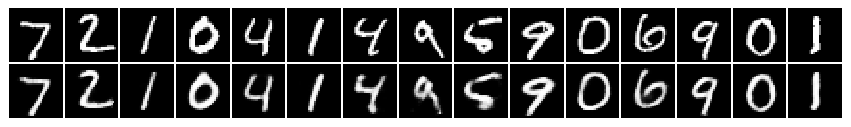

epoch 4 | iter 700 | acc_cost 0.8156 | cost 0.0090
epoch 4 | iter 800 | acc_cost 0.7862 | cost 0.0083


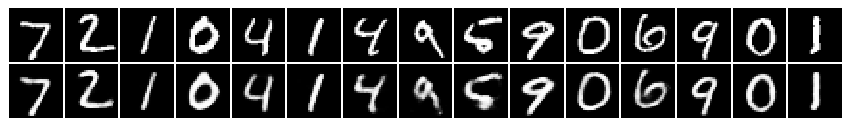

epoch 4 | iter 900 | acc_cost 0.8053 | cost 0.0084
epoch 4 | iter 1000 | acc_cost 0.8100 | cost 0.0077


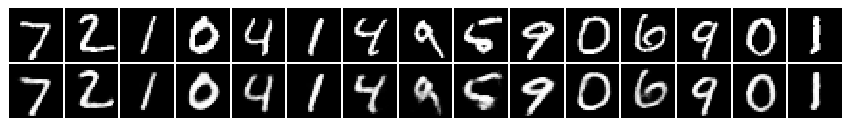

epoch 4 | iter 1100 | acc_cost 0.8020 | cost 0.0074
epoch 4 | iter 1200 | acc_cost 0.8024 | cost 0.0078


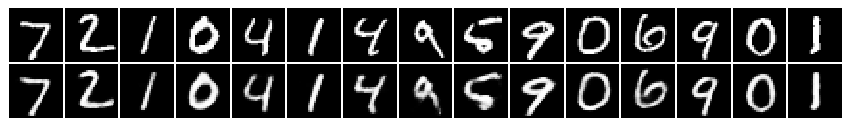

epoch 4 | iter 1300 | acc_cost 0.8088 | cost 0.0086
epoch 4 | iter 1400 | acc_cost 0.8177 | cost 0.0076


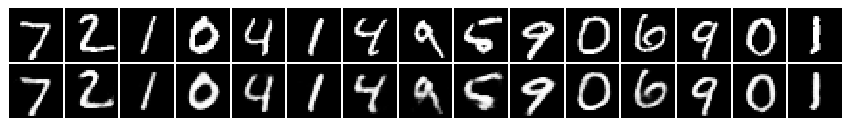

epoch 4 | iter 1500 | acc_cost 0.7970 | cost 0.0087
epoch 4 | iter 1600 | acc_cost 0.7941 | cost 0.0075


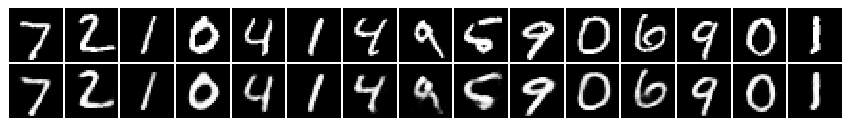

epoch 4 | iter 1700 | acc_cost 0.8048 | cost 0.0088
epoch 4 | iter 1800 | acc_cost 0.7878 | cost 0.0087


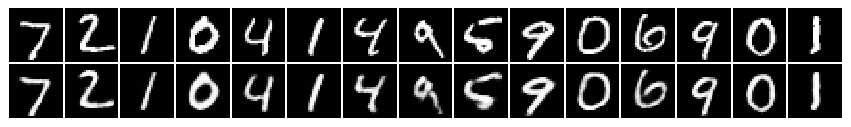

In [126]:
ae.apply(init_params)
total_epochs = 5

LOG_INTERVAL = 100
SUMMARY_INTERVAL = 200

acc_cost = 0

for epoch in range(0,total_epochs):
    for i, (x, y) in enumerate(train_dl):
        optim.zero_grad()
        x = x.to(device)
        target = ae(x).unsqueeze(1)
        cost = mse_loss(x, target)
        acc_cost += cost.item()
        cost.backward()
        optim.step()
        
        if (i%LOG_INTERVAL) == 0:
            print(f"epoch {epoch} | iter {i} | acc_cost {acc_cost:.4f} | cost {cost:.4f}")
            acc_cost = 0       
        
        if (i%SUMMARY_INTERVAL)==0:
            show_summary_1(valid_dl,ae)
        